# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

<div class="alert alert-info">
<b>План работы. 
    1. Загрузить и изучить датасет.
    2. Сделать предобработку данных (найти/заменить пропуски, аномалии, проч.).
    3. Провести исследовательский анализ данных в соответствии с заданием.</b>
    
    Описание данных. 
    airports_nearest — расстояние до ближайшего аэропорта в метрах (м).
    balcony — число балконов
    ceiling_height — высота потолков (м)
    cityCenters_nearest — расстояние до центра города (м)
    days_exposition — сколько дней было размещено объявление (от публикации до снятия)
    first_day_exposition — дата публикации
    floor — этаж
    floors_total — всего этажей в доме
    is_apartment — апартаменты (булев тип)
    kitchen_area — площадь кухни в квадратных метрах (м²)
    last_price — цена на момент снятия с публикации
    living_area — жилая площадь в квадратных метрах (м²)
    locality_name — название населённого пункта
    open_plan — свободная планировка (булев тип)
    parks_around3000 — число парков в радиусе 3 км
    parks_nearest — расстояние до ближайшего парка (м)
    ponds_around3000 — число водоёмов в радиусе 3 км
    ponds_nearest — расстояние до ближайшего водоёма (м)
    rooms — число комнат
    studio — квартира-студия (булев тип)
    total_area — общая площадь квартиры в квадратных метрах (м²)
    total_images — число фотографий квартиры в объявлении 
</div>

### Откроем файл с данными и изучим общую информацию

In [605]:
import pandas as pd

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()
data.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

0

<div class="alert alert-info">
<b>Вывод: 1. В данных есть пропуски в столбцах ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, столбцы геоданных, days_exposition. 2. Типы данных в некоторых столбцах, таких как last_price, first_day_exposition, floors_total, is_apartment, balcony, days_exposition,  необходимо (или рекомендуется для экономии памяти) изменить 3. Выбросы/аномалии присутствуют в нескольких столбцах, это предмет дальнейшего исследования. 4. Явных дубликатов нет. 5. В столбце locality_name есть неявные дубликаты.</b> 
</div>

### Выполните предобработку данных

1. Заполняем пропуски в столбцах.

1.1 Заполняем пропуски в столбце "ceiling_height". Насколько я понимаю, чисткой/заменой аномальных значений мы должны были заниматься на следующих этапах, а пока заменить nan на медиану. 

а) Минимальная высота потолков для квартир даже для эконом-класса - 2,5 м (для Санкт-Петербурга и окрестностей предположим, что 2,4 м - тоже реальная высота потолка). Все, что ниже (есть значения от 1 м) - неверно введенные данные, но их так мало, что можно их оставить при подсчете медианы (первая самая частая аномалия - высота 2 м - всего 11 значений). 

In [606]:
ceiling_median = data['ceiling_height'].median()
print(ceiling_median)
data['ceiling_height']  = data['ceiling_height'].fillna(ceiling_median)
temp = data['ceiling_height'].unique()
temp.sort()
print(temp) # при выводе уже нет никаких пропущенных значений, но все еще есть аномалии, типа высота = 25 метров 

2.65
[  1.     1.2    1.75   2.     2.2    2.25   2.3    2.34   2.4    2.45
   2.46   2.47   2.48   2.49   2.5    2.51   2.52   2.53   2.54   2.55
   2.56   2.57   2.58   2.59   2.6    2.61   2.62   2.63   2.64   2.65
   2.66   2.67   2.68   2.69   2.7    2.71   2.72   2.73   2.74   2.75
   2.76   2.77   2.78   2.79   2.8    2.81   2.82   2.83   2.84   2.85
   2.86   2.87   2.88   2.89   2.9    2.91   2.92   2.93   2.94   2.95
   2.96   2.97   2.98   2.99   3.     3.01   3.02   3.03   3.04   3.05
   3.06   3.07   3.08   3.09   3.1    3.11   3.12   3.13   3.14   3.15
   3.16   3.17   3.18   3.2    3.21   3.22   3.23   3.24   3.25   3.26
   3.27   3.28   3.29   3.3    3.31   3.32   3.33   3.34   3.35   3.36
   3.37   3.38   3.39   3.4    3.42   3.43   3.44   3.45   3.46   3.47
   3.48   3.49   3.5    3.51   3.52   3.53   3.54   3.55   3.56   3.57
   3.58   3.59   3.6    3.62   3.63   3.65   3.66   3.67   3.68   3.69
   3.7    3.75   3.76   3.78   3.8    3.82   3.83   3.84   3.85   3.86
 

б) тем не менее, заменим аномальные значения: от 1 м до 2.34 м, а также 8., 8.3, 10.3, 14., 20., 22.6, 100. - на медиану, а правдоподобно выглядящие значения, но с неправильно забитой точкой (24, 25, 26, 27, 27.5, 32) - на соответствующие значения (2.4, 2.5, 2.6, 2.7, 2.75, 3.2). Предположим при этом, что высота потолков до 6 м - реальная высота (ее менять не будем).

In [607]:
data.loc[data['ceiling_height'] < 2.4, 'ceiling_height'] = ceiling_median

data['ceiling_height'] = (
    data['ceiling_height']
    .replace([8., 8.3, 10.3, 14., 20., 22.6, 100.], ceiling_median)
)

data.loc[data['ceiling_height'] > 23, 'ceiling_height'] = data.loc[data['ceiling_height'] > 23, 'ceiling_height'] / 10
    
temp = data['ceiling_height'].unique()
temp.sort()
print(temp)

[2.4  2.45 2.46 2.47 2.48 2.49 2.5  2.51 2.52 2.53 2.54 2.55 2.56 2.57
 2.58 2.59 2.6  2.61 2.62 2.63 2.64 2.65 2.66 2.67 2.68 2.69 2.7  2.71
 2.72 2.73 2.74 2.75 2.76 2.77 2.78 2.79 2.8  2.81 2.82 2.83 2.84 2.85
 2.86 2.87 2.88 2.89 2.9  2.91 2.92 2.93 2.94 2.95 2.96 2.97 2.98 2.99
 3.   3.01 3.02 3.03 3.04 3.05 3.06 3.07 3.08 3.09 3.1  3.11 3.12 3.13
 3.14 3.15 3.16 3.17 3.18 3.2  3.21 3.22 3.23 3.24 3.25 3.26 3.27 3.28
 3.29 3.3  3.31 3.32 3.33 3.34 3.35 3.36 3.37 3.38 3.39 3.4  3.42 3.43
 3.44 3.45 3.46 3.47 3.48 3.49 3.5  3.51 3.52 3.53 3.54 3.55 3.56 3.57
 3.58 3.59 3.6  3.62 3.63 3.65 3.66 3.67 3.68 3.69 3.7  3.75 3.76 3.78
 3.8  3.82 3.83 3.84 3.85 3.86 3.87 3.88 3.9  3.93 3.95 3.98 4.   4.06
 4.1  4.14 4.15 4.19 4.2  4.25 4.3  4.37 4.4  4.45 4.5  4.65 4.7  4.8
 4.9  5.   5.2  5.3  5.5  5.6  5.8  6.  ]


In [608]:
floor_nan = data.loc[data['floors_total'].isna(), 'floor']
print(floor_nan) # оказывается, это просто пропуски (этажи разные), поэтому можно только заменить 
                 # пропуск на номер этажа, типа это последний этаж
data.loc[data['floors_total'].isna(), 'floors_total'] = data.loc[data['floors_total'].isna(), 'floor']
temp = data['floors_total'].unique()
print(temp)


#data['floors_total'].isna().sum() #86 пропусков - скорее всего, это объявления по квартирам с одноэтажными домами 
# и не было необходимости указывать этаж, поэтому заменим пропуски на единицы
#data['floors_total'] = data['floors_total'].fillna(1)
#temp = data['floors_total'].unique()
#temp.sort()
#temp

186       4
237       1
457      12
671       8
1757      9
         ..
22542     3
22656    20
22808     6
23590    18
23658     8
Name: floor, Length: 86, dtype: int64
[16. 11.  5. 14. 12. 26. 24. 27.  9.  6. 17. 25.  3. 23. 19. 18.  4. 22.
  8.  2. 10.  7. 13. 15.  1. 20. 28. 36. 21. 35. 34. 60. 29. 33. 52. 37.]


In [609]:
#data['living_area'].isna().sum()
#print(data['living_area'].unique())
la_median = data['living_area']/data['total_area']
la_median = la_median.median()
data['living_area']  = data['living_area'].fillna(la_median)
#print(data['living_area'].value_counts())
#print(data.info())
#Самое часто встречающееся значение = 0.5679599 похоже на процент от общей площади, \
#поэтому вставляем вместо него долю от общей площади:
data.loc[(data['living_area']  < 1), 'living_area'] = \
data.loc[(data['living_area'] < 1), 'total_area'] * data.loc[(data['living_area']  < 1), 'living_area']
print(data['living_area'].value_counts())
#print(data)

print(data.loc[(data['living_area'] > data['total_area']),:]) # строк, где жилая площадь превышает общую, нет



18.000000     882
17.000000     675
30.000000     598
16.000000     486
20.000000     481
             ... 
34.760002       1
44.520216       1
131.500000      1
71.200000       1
16.740000       1
Name: living_area, Length: 2441, dtype: int64
Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


1.3 Заполняем пропуски в столбце is_apartment. Очевидно, если есть пропуск, то это не апартаменты и нужно заполнить ячейку
значением False.

In [610]:
data['is_apartment'] = data['is_apartment'].fillna(False)
#data.info()

1.4 Площадь кухни не всегда коррелирует с общей или жилой площадью, поэтому разделим заполнение пропусков в этом столбце на 2 части.

In [611]:
#1. Проверяем, если это студия и у нее не указана площадь кухни, то площадь кухни = 0.

#print(len(data[data['kitchen_area'].isna()])) # всего пропусков в столбце
data.loc[(data['kitchen_area'].isna() & data['studio'] == True), 'kitchen_area'] = 0 # здесь заменили 149 значений
#print(data.info())

# 2. Если это не студия - заполняем пропуски медианами в зависимости от кол-ва комнат:
for i in data['rooms'].unique():
    data.loc[(data['rooms'] == i) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['rooms'] == i), 'kitchen_area'].median()
#data.info()

#3. проверяем превышение площади кухни над общей площадью:

print(data.loc[(data['kitchen_area'] > data['total_area']),:]) # таких строк нет

#4. Проверяем  превышение суммы площадей всей площади

#print(data.loc[((data['living_area'] + data['kitchen_area']) > data['total_area']),:])
temp = data.loc[((data['living_area'] + data['kitchen_area']) > data['total_area']),:]
temp['total_area'].count() # 199 строк, где сумма жилой и площади кухни больше общей площади. 
                           #Получается, где-то в этих строках некорректные данные, но где именно - непоянтно, поэтому
                           # думаю, лучше избавиться от таких строк:
data = data.loc[((data['living_area'] + data['kitchen_area']) <= data['total_area']),:]
data.info()

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23500 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23500 non-null  int64  
 1   last_price            23500 non-null  float64
 2   total_area            23500 non-null  float64
 3   first_day_exposition  23500 non-null  object 
 4   rooms                 23500 non-null  int64  
 5   ceiling_height        23500 non-null  float64
 6   floors_total          23500 non-null  float64
 7   living_area           23500 non-null  float64
 8   floor  

1.5 Заполняем пропуски в столбце balcony - nan заменяем на 0, так как если не указано число, то балконов нет:

In [612]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

1.6 Заполняем пропуски в столбце locality_name.  Пропуски, скорее всго, появились потому, что имеется ввиду Санкт_Петербург и должен быть еще столбец с адресом (ул. Такая-то, дом Такой-то), но его нет. Пропуcки, на мой взгляд, нужно заменить на "Санкт-Петербург".

In [613]:
data['locality_name'] = data['locality_name'].fillna('Санкт-Петербург')

Не заполняем пропуски в геоданных, полученных автоматически, т.к. мы не можем определить никаких корреляций здесь и если станем заполнять пропуски, это может исказить результаты исследования. 

1.7 Заполняем пропуски в days_exposition: насколько я понимаю, пропуски- это нули (т.е. квартира висела в продаже в течение 1 дня).

In [614]:
data['days_exposition'] = data['days_exposition'].fillna(0) 
data['days_exposition'].astype(int)
#temp = data['days_exposition'].unique()
#temp
#data.info()

0          0
1         81
2        558
3        424
4        121
        ... 
23694      0
23695     45
23696      0
23697    602
23698      0
Name: days_exposition, Length: 23500, dtype: int64

2. Меняем типы данных. 

In [615]:
data['last_price'] = data['last_price'].astype(int) # т.к. среди значений нет дробных, можно сэкономить память и поменять тип данных на Int
data['first_day_exposition'] = data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%d') #меняем тип данных на дату
data['floors_total'] = data['floors_total'].astype(int) # т.к. среди значений нет дробных, можно сэкономить память и поменять тип данных на Int
data['balcony'] = data['balcony'].astype(int) # т.к. среди значений нет дробных, можно сэкономить память и поменять тип данных на Int
data['days_exposition'] = data['days_exposition'].astype(int) # т.к. среди значений нет дробных, можно сэкономить память и поменять тип данных на Int
data.info()
# в столбце 'is_apartment' уже тип данных поменялся на bool (видимо, при присвоении значений False), так что не меняем его

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23500 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23500 non-null  int64         
 1   last_price            23500 non-null  int64         
 2   total_area            23500 non-null  float64       
 3   first_day_exposition  23500 non-null  datetime64[ns]
 4   rooms                 23500 non-null  int64         
 5   ceiling_height        23500 non-null  float64       
 6   floors_total          23500 non-null  int64         
 7   living_area           23500 non-null  float64       
 8   floor                 23500 non-null  int64         
 9   is_apartment          23500 non-null  bool          
 10  studio                23500 non-null  bool          
 11  open_plan             23500 non-null  bool          
 12  kitchen_area          23500 non-null  float64       
 13  balcony         

3. Исключаем неявные дубликаты в столбце "locality_name"

In [616]:
#data['locality_name'].unique()
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'городской поселок', 'коттеджный поселок'], 'поселок', regex=True)
) 
sorted = data['locality_name'].sort_values()
sorted.value_counts()

Санкт-Петербург       15657
поселок Мурино          533
поселок Шушары          436
Всеволожск              394
Пушкин                  369
                      ...  
деревня Каськово          1
деревня Снегиревка        1
поселок Левашово          1
поселок Семиозерье        1
поселок Ромашки           1
Name: locality_name, Length: 321, dtype: int64

In [617]:
data['meter_price'] = round(data['last_price'] / data['total_area'], 2) # цена 1 кв. м.
data['weekday'] = data['first_day_exposition'].dt.weekday # день недели публикации объявления
print(data['weekday'])
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month # месяц публикации объявления
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year # год публикации объявления


0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: weekday, Length: 23500, dtype: int64


3.2. Добавляем столбец "тип этажа" - floor_type

In [618]:
#data['floor'].unique()
rows = data['floor'] == 1 # для начала - только первый этаж
data.loc[rows, 'floor_type'] = 'первый' 

rows = data['floor'] == data['floors_total'] # теперь - последний этаж
data.loc[rows, 'floor_type'] = 'последний'

data['floor_type'] = data['floor_type'].fillna('другой') # остается только заполнить пропуски третьей категорией - "другой"
#print(data['floor_type'].head(20))



3.3. Добавляем столбец с расстоянием до центра города в километрах (переведем из м в км и округлим до ближайших целых значений).

In [619]:
data['dist_to_centre'] = round(data['cityCenters_nearest']/1000, 0)
print(data['dist_to_centre'])

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: dist_to_centre, Length: 23500, dtype: float64


### Проведите исследовательский анализ данных

4.1. Строим гистограммы / боксплоты, чтобы увидеть аномалии.

Будем считать, что квартиры более 400 кв.м. - это аномалии

count    23500.000000
mean        60.549031
std         35.673829
min         14.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

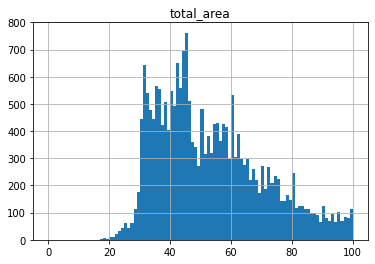

In [620]:
import matplotlib.pyplot as plt
data.hist('total_area', bins = 100, range = (0, 100)) # 
#data['total_area'].value_counts()
#print(data.info())
data['total_area'].describe()



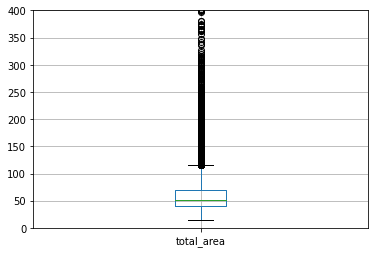

In [621]:
plt.ylim(0, 400)
data.boxplot(column='total_area')
data = data[(data['total_area'] <= 350)] # по идее, все значения больше 120 - выбросы, но так как их достаточно 
                               # много (сплошная линия на графике, удалим значения больше 350 - аномалии, которые отстоят от 
                               # общего массива данных (на графике линия превращается в набор точек)
#print(data['total_area'].describe())
#print(data.info())

<div class="alert alert-info">
<b> Распределение похоже на нормальное, есть пики в районе 32 кв.м., что соответствует 1-комнатной квартире/студии, 45 кв.м. (2-комн. кв.), 60 кв.м. 2-3 комн. кв, и 80 кв.м. (3-4 комн. кв.). Среднее и медиана близко друг к другу (59,8 и 52), что говорит о равномерном распределении значений по оси Х, но наличие максимума 900 говорит о том, что скорее всего, в этом районе значений есть выброс(ы).  </b> 
</div>

count    23459.000000
mean        34.253170
std         20.279346
min          2.000000
25%         19.000000
50%         30.000000
75%         42.060816
max        260.000000
Name: living_area, dtype: float64

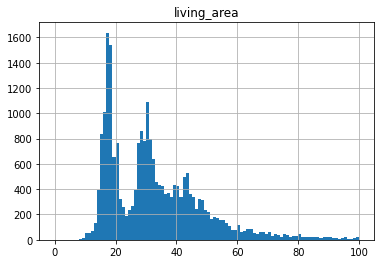

In [622]:
data.hist('living_area', bins = 100, range = (0, 100))
data['living_area'].describe()


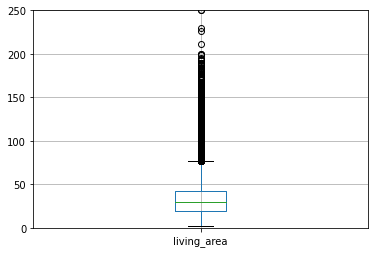

In [623]:
plt.ylim(0, 250)
data.boxplot(column='living_area')
data = data[(data['living_area'] <=200)] # все значения больше 200 - аномалии, удаляем их
#print(data.info())

<div class="alert alert-info">
<b> Значения до 10 м  (хоть они и входят в межквартильный интервал), очевидно, являются некорректными, необходимо их удалить. Кроме того, значения больше 200 - тоже считаем достойными удаления выбросами, т.к. после 200 м линия на боксплоте начинает прерываться. Видны 3 ярко выраженных пика - 15-20 м, 27-33 м, 43 45 м. (также скорее всего соответствуют 1-комн/студии, 2-комн. и 3-комн. квартирам.    </b> 
</div>

count    23452.00000
mean        10.30802
std          5.51464
min          0.00000
25%          7.20000
50%          9.00000
75%         11.50000
max        107.00000
Name: kitchen_area, dtype: float64

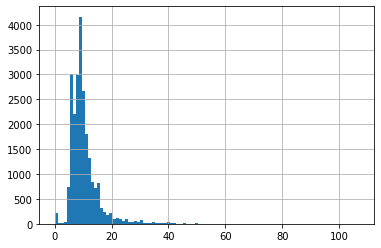

In [624]:
data['kitchen_area'].hist(bins = 100) # 
data['kitchen_area'].describe()

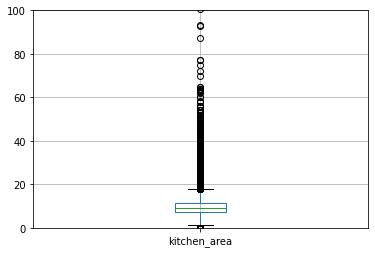

In [625]:
plt.ylim(0, 100)
data.boxplot(column='kitchen_area')
data = data[(data['kitchen_area'] <= 65)] # все значения больше 65 - аномалии, удаляем их
#print(data.info())

<div class="alert alert-info">
<b> В этом столбце присутствуют нулевые значения, но это не выбросы, а студии, необходимо их оставлять. В целом, распределение похоже на нормальное, среднее и медиана почти равны (10,3 и 9), но, судя по боксплоту, есть значительное количество аномальных значений (которые в целом перевешиваются нулевыми с другого конца графика). Принято решение избавиться от значений больше 65 (свыше этого значения линия "уса" на графике начинает прерываться).      </b> 
</div>

count    2.344200e+04
mean     6.323202e+06
std      7.791650e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.775000e+06
max      3.300000e+08
Name: last_price, dtype: float64

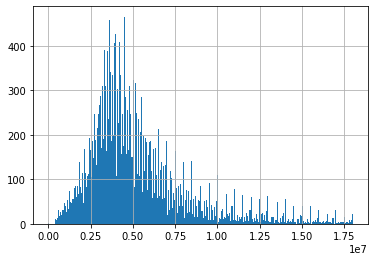

In [626]:
data['last_price'].hist(bins=300, range = (0, 18000000)) # практически идеальное нормальное распределение 
data['last_price'].describe()                           # с правым хвостом, означающим аномально  большие значения
#data['last_price'].value_counts()


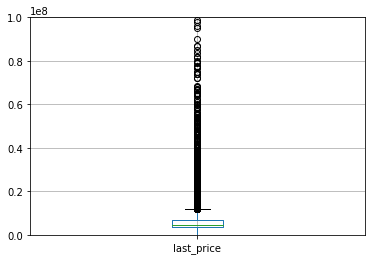

In [627]:
plt.ylim(0, 100000000)
data.boxplot(column='last_price')
data = data[(data['last_price'] <= 90000000)] # все значения больше 90 000 000 - аномалии, удаляем их, т.к. они 
                                              # отстоят на значительном расстоянии от основной линии выбросов на боксплоте
#print(data.info())

<div class="alert alert-info">
<b> Столбец last_price характеризуется распределением значений, похожим на нормальное, с одним пиком и длинным правым хвостом, означающим аномально большие значения, (от 90 млн и выше - от них избавляемся).       </b> 
</div>

count    23416.000000
mean         2.063931
std          1.046175
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64

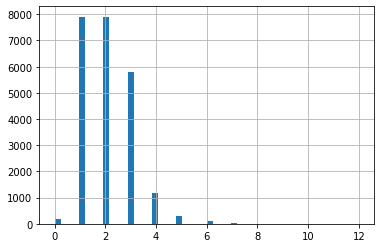

In [628]:
data['rooms'].hist(bins=50, range = (0, 12)) # 
data['rooms'].describe()


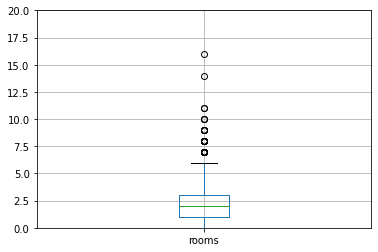

In [629]:
plt.ylim(0, 20)
data.boxplot(column='rooms')
data = data[(data['rooms'] <= 6)] # все значения больше 6 - аномалии, удаляем их
#print(data.info())

<div class="alert alert-info">
<b> Столбец rooms так же характеризуется распределением значений, похожим на нормальное, с одним пиком на значениях 1 и 2 комнат. При стандартном отклонении 1 максимальное значение =16, очевидно, в этом районе выбросы. Это подтверждается на графике боксплот - предел нормальных значений - до 6 комнат, остальное - выбросы.    </b> 
</div>

count    23353.000000
mean         2.694023
std          0.212087
min          2.400000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.800000
Name: ceiling_height, dtype: float64

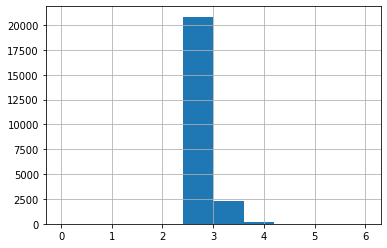

In [630]:
data['ceiling_height'].hist(bins=10, range = (0, 6)) # 
data['ceiling_height'].describe()

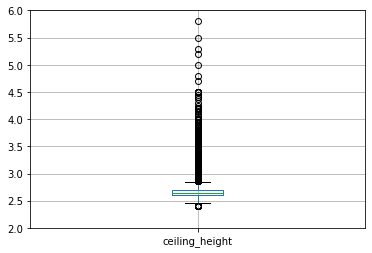

In [631]:
plt.ylim(2, 6)
data.boxplot(column='ceiling_height')
data = data[(data['ceiling_height'] <= 4.5)] # все значения больше 4.5 - аномалии, отстающие от основной 
                                              #группы значений (даже от основной линии выбросов), удаляем их
#print(data.info())

<div class="alert alert-info">
<b> Для столбца ceiling_height мы уже ранее обрабатывали значения (в т.ч. заменили медианой все значения больше 6 метров, приняв для начала 6 метров как самое высокую стандартную высоту потолка). Дальнейший анализ (график боксплот) со всей очевидностью показывает, что высоты потолков от 4,5 до 6 метров - тоже выбросы, их мало и ими, имхо, можно пренебречь. </b> 
</div>

другой       17119
последний     3372
первый        2855
Name: floor_type, dtype: int64

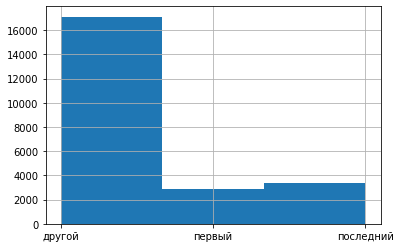

In [632]:
data['floor_type'].hist(bins=3) # 
data['floor_type'].value_counts()

<div class="alert alert-info">
<b> Здесь описывать особо нечего, очевидно, тип "другой" будет встречаться гораздо чаще, чем "первый" или "последний", которые встречаются в данных примерно одинаково часто. </b> 
</div>

count    23346.000000
mean        10.668337
std          6.583236
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

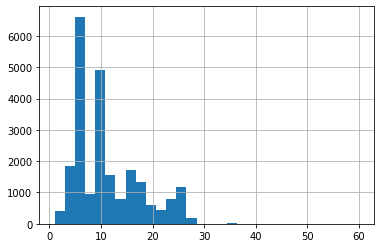

In [633]:
data['floors_total'].hist(bins=30) 
data['floors_total'].describe()
#data['floors_total'].value_counts()


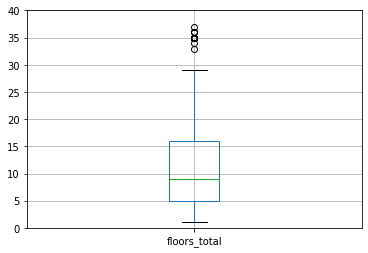

In [634]:
plt.ylim(0, 40)
data.boxplot(column='floors_total') # 
data = data[(data['floors_total'] <= 30)] # избавляемся от выбросов, т.к. они лежат за пределами стандартных значений и их мало


<div class="alert alert-info">
<b> Больше всего в выборке 5-этажек и 9-этажек. 9-этажей - это кроме того и медиана. Максимальное значение - 60 этажей при стандартном отклонении 6,5 - очевидно наличие выбросов, что и показывает боксплот. Удаляем все строки с количеством этажей  больше 30. </b> 
</div>

count    17878.000000
mean     14257.358765
std       8605.773459
min        181.000000
25%       9380.000000
50%      13138.000000
75%      16297.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

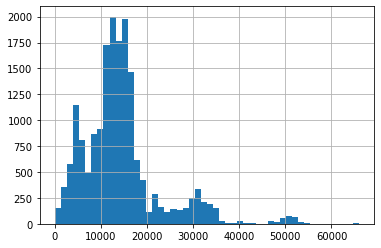

In [635]:
data['cityCenters_nearest'].hist(bins=50, range = (0, 66000)) # 
data['cityCenters_nearest'].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23315 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23315 non-null  int64         
 1   last_price            23315 non-null  int64         
 2   total_area            23315 non-null  float64       
 3   first_day_exposition  23315 non-null  datetime64[ns]
 4   rooms                 23315 non-null  int64         
 5   ceiling_height        23315 non-null  float64       
 6   floors_total          23315 non-null  int64         
 7   living_area           23315 non-null  float64       
 8   floor                 23315 non-null  int64         
 9   is_apartment          23315 non-null  bool          
 10  studio                23315 non-null  bool          
 11  open_plan             23315 non-null  bool          
 12  kitchen_area          23315 non-null  float64       
 13  balcony         

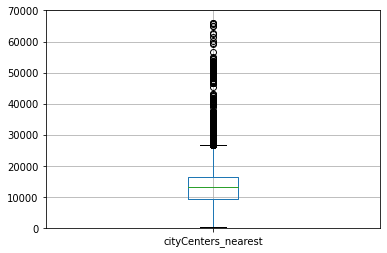

In [636]:
plt.ylim(0, 70000)
data.boxplot(column='cityCenters_nearest') #крайние значения плотные и их много, скорее всего, это уже другие города/ микрорайоны 
#data = data[(data['cityCenters_nearest'] <= 36000)] # ничего не удаляем, т.к. удаляются также и незаполненные значения
print(data.info())


<div class="alert alert-info">
<b> На гистограмме видны несколько пиков, например, в 5 км от центра, далее в районе 10-15 км, 30 км. Это может говорить о географии продаж, например, о том факте, что непосредственно в центре города квартиры продаются мало из-за дорогой земли и, как следствие, отсутствия новостроек. То же можно сказать и о самом крупном сегменте - объявлениях в 10-15 км от центра. Очевидно, это спальные районы с относительно низкой стоимостью земли, ее доступностью, но и одновременно доступной транспортной и социальной инфраструктурой. Здесь мы ничего не удаляем, т.к. данные потребуются для дальнейших вычислений. </b> 
</div>

count    7920.000000
mean      491.446212
std       342.246871
min         1.000000
25%       288.000000
50%       455.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

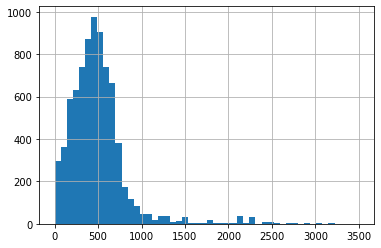

In [637]:
data['parks_nearest'].hist(bins=50, range = (0, 3500))
data['parks_nearest'].describe()


<AxesSubplot:>

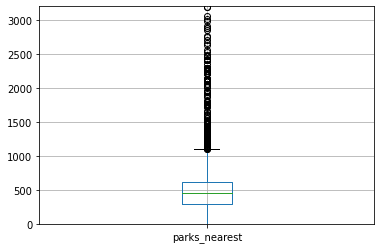

In [638]:
plt.ylim(0, 3200)
data.boxplot(column='parks_nearest') # - ничего не удаляем, т.к. удаляются, видимо, так же и незаполненные значения.


<div class="alert alert-info">
<b> Эта гистограмма похожа на нормальное распределение, с одним пиком в районе 500 м от парка (видимо нормы планировки и застройки территории городов предусматривают именно это значение в качестве базового при планировании территории, или так просто совпало). Также присутствует  правый хвост из аномальных значений. Но тем не менее, не хотелось бы здесь ничего удалять, т.к., во-первых, при фильтрации удаляются также и незаполненные значения (а чем их заполнить - непонятно), а во-вторых, эти аномалии не сильно влияют на выборку (среднее и медиана блиски друг к другу, стандартное отклонение почти в 1,5 меньше среднего. </b> 
</div>

4.2. Изучаем, как быстро продавались квартиры. 

Среднее число дней продажи квартиры= 156.49011366073344
Медианное число дней продажи квартиры= 74.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23315 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23315 non-null  int64         
 1   last_price            23315 non-null  int64         
 2   total_area            23315 non-null  float64       
 3   first_day_exposition  23315 non-null  datetime64[ns]
 4   rooms                 23315 non-null  int64         
 5   ceiling_height        23315 non-null  float64       
 6   floors_total          23315 non-null  int64         
 7   living_area           23315 non-null  float64       
 8   floor                 23315 non-null  int64         
 9   is_apartment          23315 non-null  bool          
 10  studio                23315 non-null  bool          
 11  open_plan             23315 non-

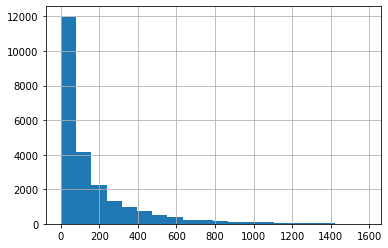

In [639]:
data['days_exposition'].hist(bins=20)
days_exp_mean = data['days_exposition'].mean()
print('Среднее число дней продажи квартиры=', days_exp_mean)
days_exp_median = data['days_exposition'].median()
print('Медианное число дней продажи квартиры=', days_exp_median)
data.info()

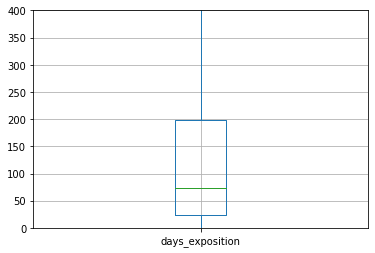

In [640]:
plt.ylim(0, 400)
data.boxplot(column='days_exposition')
data = data[(data['days_exposition'] <= 1460)] # все значения больше 1460 - аномалии, удаляем их
#print(data.info())

 Обычно квартира продается 73 дня.  Все продажи больше 400 дней можно считать необычно долгими. Обычной быстрой продажей можно считать продажу сроком от 0 до 25 дней.  

4.3. Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.
Изучим, зависит ли цена от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).

In [641]:
total_area_pivot = data.pivot_table(index='last_price', values='total_area') 
print(total_area_pivot)

            total_area
last_price            
12190       109.000000
430000       42.200000
440000       40.000000
450000       40.100000
470000       40.833333
...                ...
83820000    153.000000
85000000    145.700000
86738800    190.000000
87000000    283.000000
90000000    225.000000

[2882 rows x 1 columns]


0.7572317523237085


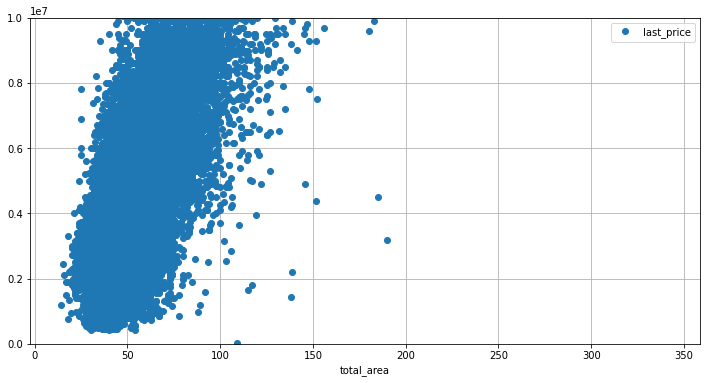

In [642]:
data.plot(x='total_area', y='last_price', style='o', ylim=(0, 10000000), grid=True, figsize=(12, 6))
print(data['last_price'].corr(data['total_area']))
#налицо очевидная сильная корреляция между общей площадью и ценой

0.6684781218929329


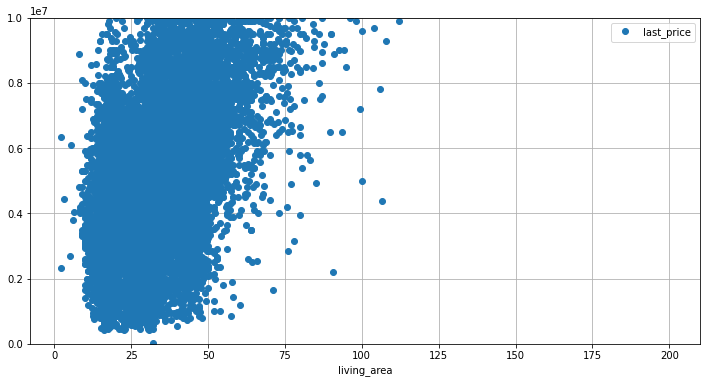

In [643]:
data.plot(x='living_area', y='last_price', style='o', ylim=(0, 10000000), grid=True, figsize=(12, 6))
print(data['last_price'].corr(data['living_area']))
# между жилой площадью и ценой также есть корреляцияЮ но она уже меньше

0.5419994445944734


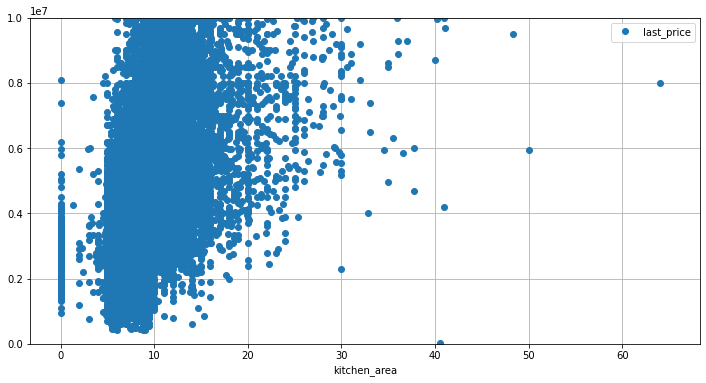

In [644]:
data.plot(x='kitchen_area', y='last_price', style='o', ylim=(0, 10000000), grid=True, figsize=(12, 6))
print(data['last_price'].corr(data['kitchen_area']))
#еще меньше зависимость цены от площади кухни, но все же она есть

0.45469359295655043


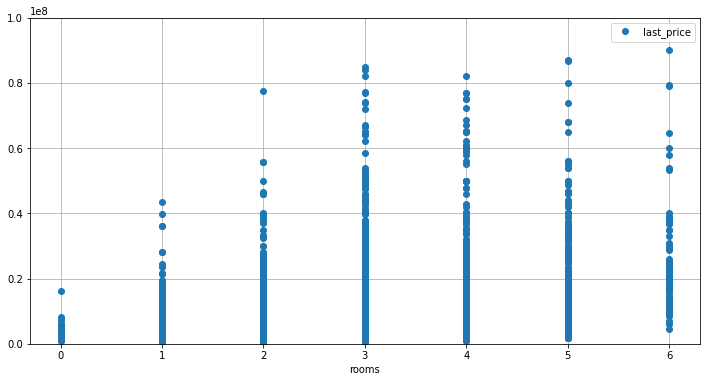

In [645]:
#rooms_dat = data.pivot_table(index='rooms', values='last_price', aggfunc=['median', 'count'])
#print(rooms_dat)                             
                             
                             
data.plot(x='rooms', y='last_price', style='o', ylim=(0, 100000000), grid=True, figsize=(12, 6))
print(data['last_price'].corr(data['rooms']))
# корреляция положительная, но не такая сильная, как предыдущие

0.055928432081670164


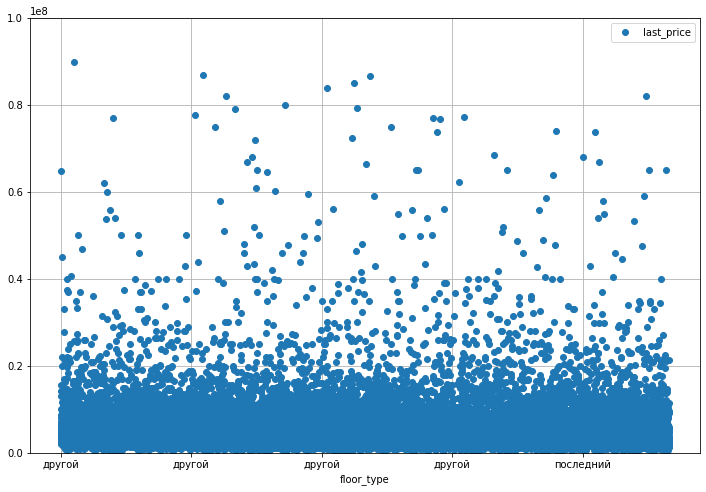

In [646]:
data.plot(x='floor_type', y='last_price', style='o', ylim=(0, 100000000), grid=True, figsize=(12, 8))

#сделаем еще один столбец- дублер столбца floor_type с числовыми значениями, чтобы посчитать коэффициент корреляции:
#print(data['floor_type'].value_counts())
rows = data['floor_type'] == 'первый' # для начала - только первый этаж
data.loc[rows, 'floor_type_2'] = 1 

rows = data['floor_type'] == 'другой' # для начала - только первый этаж
data.loc[rows, 'floor_type_2'] = 2 

rows = data['floor_type'] == 'последний' # теперь - последний этаж
data.loc[rows, 'floor_type_2'] = 3


#print(data['floor_type_2'].value_counts())  

print(data['last_price'].corr(data['floor_type_2']))
#по этажам сильной зависимости не наблюдается

<div class="alert alert-info">
<b> Делаем обычную гистограмму: </b> 
</div>

<AxesSubplot:>

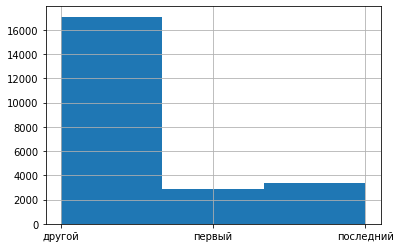

In [647]:
data['floor_type'].hist(bins=3)


<AxesSubplot:>

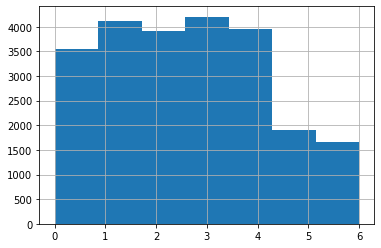

In [648]:
data['weekday'].hist(bins=7)

<AxesSubplot:ylabel='Frequency'>

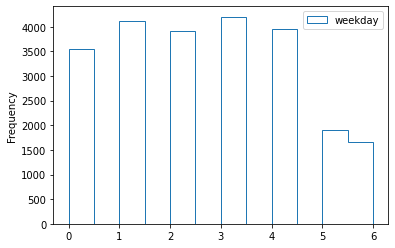

In [649]:
data.plot(kind = 'hist', y = 'weekday', histtype = 'step', bins = 12)

-0.005942463439207396


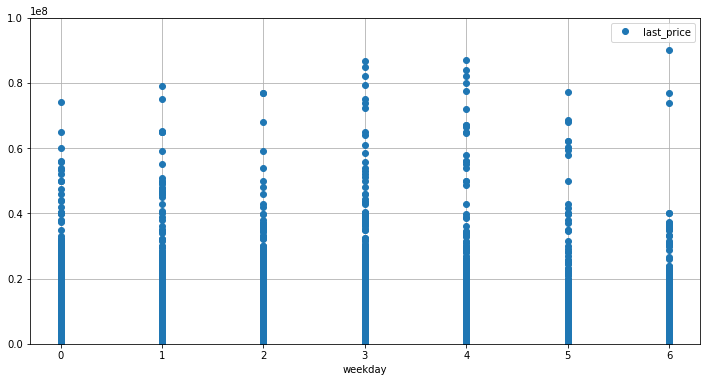

In [650]:
#цена от дня недели подачи объявления не зависит:
data.plot(x='weekday', y='last_price', style='o', ylim=(0, 100000000), grid=True, figsize=(12, 6))
print(data['last_price'].corr(data['weekday']))

<AxesSubplot:ylabel='Frequency'>

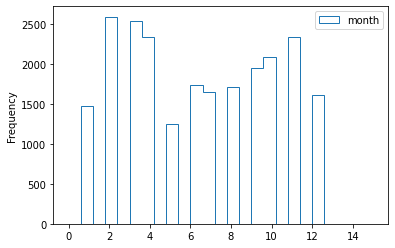

In [651]:
# делаем гистограмму для месяцев:
data.plot(kind = 'hist', y='month', histtype = 'step', range = (0, 15), bins = 25)


0.007193635295872967


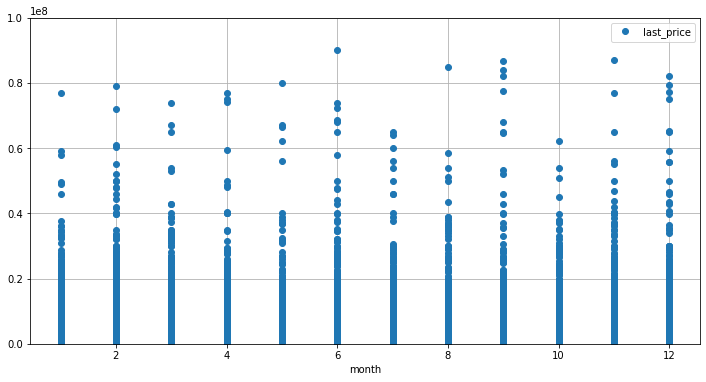

In [652]:
# цена от месяца подачи объявления не зависит:
data.plot(x='month', y='last_price', style='o', ylim=(0, 100000000), grid=True, figsize=(12, 6))
print(data['last_price'].corr(data['month']))

-0.05594996133067013


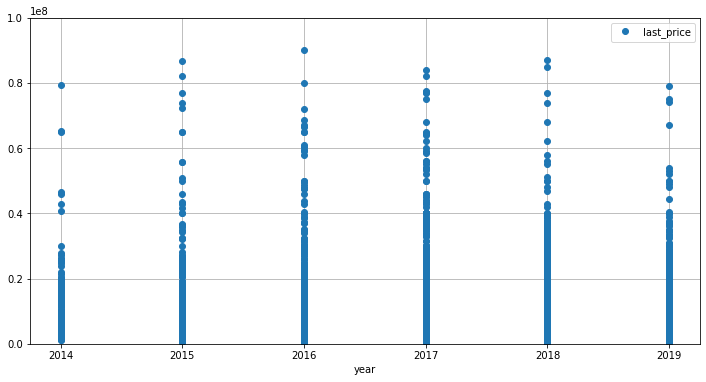

In [653]:
data.plot(x='year', y='last_price', style='o', ylim=(0, 100000000), grid=True, figsize=(12, 6))
print(data['last_price'].corr(data['year']))

In [654]:
#last_price_stat_multi = data.pivot_table(index='last_price', values= ['weekday', 'month', 'year'])
#print(last_price_stat_multi.corr())
#pd.plotting.scatter_matrix(last_price_stat_multi, figsize=(9, 9)) 

Вывод: Факторы, которые больше всего влияют на общую (полную) стоимость объекта: 
        - общая площадь (с коэффициентом корреляции 0,76)
        - жилая площадь (с коэффициентом корреляции 0.68)
        - площадь кухни (с коэффициентом корреляции 0.53)
        - количество комнат (с коэффициентом корреляции 0.47).
        Остальные критерии (этаж, день недели, месяц год) не влияют на стоимость или влияют в очень малой степени.

4.4. Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

                     meter_price
locality_name                   
Санкт-Петербург    113139.953181
Пушкин             103132.921913
деревня Кудрово     92277.302168
поселок Парголово   90291.780185
поселок Мурино      85436.195929
поселок Шушары      78487.495206
Колпино             75295.341075
Гатчина             68625.141155
Всеволожск          68569.675838
Выборг              58154.339746
Самая высокая цена кв. метра =                    meter_price
locality_name                 
Санкт-Петербург  113139.953181
Самая низская цена кв. метра =                 meter_price
locality_name              
Выборг         58154.339746


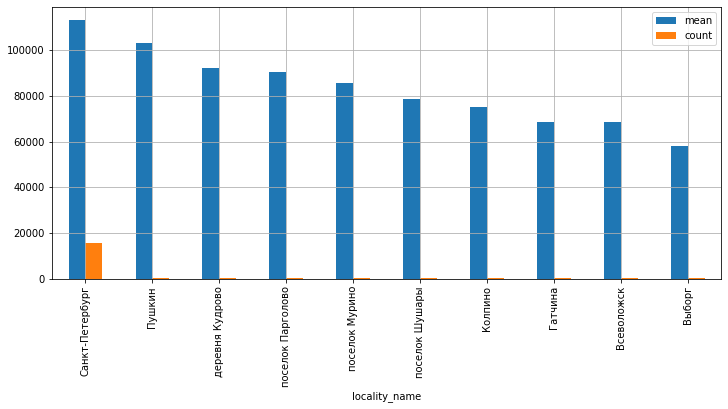

In [655]:
#data.info()
adv_count = data['locality_name'].value_counts()
adv_count = adv_count.head(10)
#print(adv_count)

new_data = data[data['locality_name'].isin(adv_count.index)] # сохраняем в новый датафрейм данные только 10 городов 
                                                            #с наибольшим кол-вом объявлений 

#print(new_data['locality_name'].value_counts())
# рисуем график:

nd =    (new_data 
    .pivot_table(index='locality_name', values='meter_price', aggfunc=['mean', 'count'])
        )
nd.columns = ['mean', 'count']
nd = nd.sort_values(by = 'mean', ascending = False)
nd.plot(kind = 'bar', grid=True, figsize=(12, 5))
#print(nd)

#ищем максимальное и минимальное значения средней стоимости кв. метра по топ-10 городам:
meter_price_mean = new_data.pivot_table(index='locality_name', values='meter_price', aggfunc='mean')
meter_price_mean = meter_price_mean.sort_values(by = 'meter_price', ascending = False)
print(meter_price_mean)
print('Самая высокая цена кв. метра =', meter_price_mean[:1] ) 
print('Самая низская цена кв. метра =', meter_price_mean[9:] )

  



Вывод: средние цены на квартиры в 10 городах с самым большим количеством объявлений варьируются от 58 141 руб за кв.м. до 113379.9 руб за кв.м. Самые дорогие квартиры в Санкт_Петербурге, самые дешевые - в Выборге.

5. Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра. Учтем каждый километр расстояния: узнаем среднюю цену квартир в одном километре от центра, в двух и так далее. Опишем, как стоимость объектов зависит от расстояния до центра города — построим график изменения средней цены для каждого километра от центра Петербурга.

                  last_price
dist_to_centre              
0.0             2.037157e+07
1.0             1.432384e+07
2.0             1.446541e+07
3.0             1.052824e+07
4.0             1.116563e+07
5.0             1.208704e+07
6.0             1.281386e+07
7.0             1.358799e+07
8.0             9.080274e+06
9.0             6.964555e+06
10.0            6.422737e+06
11.0            6.245882e+06
12.0            5.839084e+06
13.0            6.090608e+06
14.0            5.620647e+06
15.0            5.852947e+06
16.0            5.384568e+06
17.0            5.214339e+06
18.0            5.122633e+06
19.0            5.070097e+06
20.0            4.611579e+06
21.0            5.522866e+06
22.0            5.422567e+06
23.0            4.851274e+06
24.0            3.841303e+06
25.0            4.229080e+06
26.0            3.993577e+06
27.0            8.300000e+06
28.0            5.026429e+06
29.0            4.236667e+06
32.0            4.175000e+06
41.0            1.712215e+07


<AxesSubplot:xlabel='dist_to_centre'>

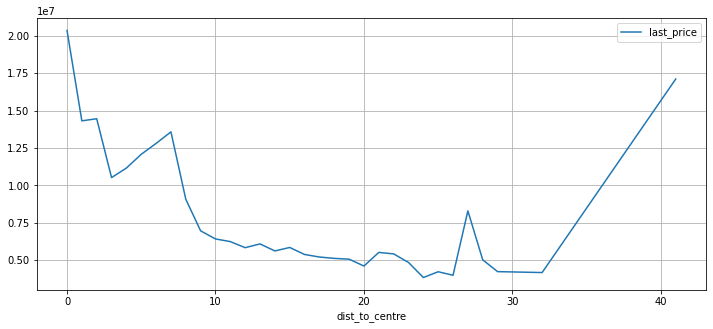

In [656]:

data_piter = data.query('locality_name == "Санкт-Петербург"') \
    .pivot_table(index='dist_to_centre', values='last_price', aggfunc = 'mean')
    #.plot(grid=True, figsize=(12, 5))
print(data_piter) 
data_piter.plot(grid=True, figsize=(12, 5))


Вывод: В центре города самые дорогие квартиры. По мере удаления от центра стоимость средняя стоимость квартиры снижается, хотя примерно с 4 до 7 км от центра наблюдается скачок, это может объясняться наличием новых милых застроек в соответствующем незначительном удалении от центра (а также тем фактом, что в самом центре в радиусе 0-4 км таких новостроек нет, поэтому там с каждым км стоимость снижается).
На значительном удалении от центра (26-28 км) есть всплеск, скорее всего - это новостройка(и). Более 30 км - это скорее всего, выброс / аномалия. 

### Напишите общий вывод

Целями проекта были:
1. Изучить общую полученную исходную информацию.Постройте гистограмму(ы)
2. Выполнить предобработку данных
- Найти, изучить пропущенные значения в столбцах, заполните пропущенные значения там, где это возможно. 
- При необходимости преобразовать типы данных в столбцах.
- Устранить неявные дубликаты. 
3. Добавить в таблицу новые столбцы со следующими параметрами:
- цена одного квадратного метра;
- день недели публикации объявления;
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах.
4. Провести исследовательский анализ данных:
- Изучите указанные в задании параметры объектов и построить отдельные гистограммы для каждого из этих параметров. Удалить/ обработать аномалии. 
- Изучить, как быстро продавались квартиры (столбец days_exposition).
- Определить факторы, которые больше всего влияют на общую (полную) стоимость объекта.
- Посчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — построить сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделить населённые пункты с самой высокой и низкой стоимостью квадратного метра.
5. Выделить квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислить их среднюю стоимость на разном удалении от центра.

Выводы: датасет в целом пригоден для анализа, хотя некоторые столбы содержали пропуски, а также аномальные значения /дубликаты. В связи с этим, пришлось осуществить этап предобработки данных, на котором были проделаны следующие работы:

1. Заполнили пропуски в столбце "ceiling_height" (заменили аномальные значения: от 1 м до 2.34 м, а также 8., 8.3, 10.3, 14., 20., 22.6, 100. - на медиану, а правдоподобно выглядящие значения, но с неправильно забитой точкой (24, 25, 26, 27, 27.5, 32) - на соответствующие значения (2.4, 2.5, 2.6, 2.7, 2.75, 3.2). Предположили при этом, что высота потолков до 6 м - реальная высота).
заполнили пропуски (86 шт) в столбце Floors_total (скорее всего, это объявления по квартирам с одноэтажными домами и не было необходимости указывать этаж, поэтому замениkb пропуски на единицы)
pаполнили пропуски в столбце living_area медианой отношения жилой к общей площади по всем имеющимся значениям.
заполнили пропуски в столбце is_apartment  значением False
заполнили пропуски в столбце kitchen_area  - для студий - значеним 0, - для остальных - медианами в зависимости от кол-ва комнат.
заполнили пропуски в столбце balcony - nan заменили на 0, так как если не указано число, то балконов нет
заполнили пропуски в столбце locality_name. Пропуски, скорее всго, появились потому, что имеется ввиду Санкт_Петербург и должен быть еще столбец с адресом (ул. Такая-то, дом Такой-то), но его в датасете нет. Пропуcки заменены на "Санкт-Петербург".
не заполняли пропуски в геоданных, полученных автоматически, т.к. мы не можем определить никаких корреляций здесь и если станем заполнять пропуски, это может исказить результаты исследования.
Заполнили пропуски в days_exposition: исходя из предположения, что это нули (т.е. квартира висела в продаже в течение 1 дня).
2. Изменили типы данных на более подходящие значениям и целях экономии памяти, а также повышения удобства исследования.
исключили неявные дубликаты в столбце "locality_name".
3. добавили необходимые столбцы.
по требуемым параметрам построены гистограммы и выявлены аномалии/ выбросы, огт которых датасет был избавлен.
4. Изучили, как быстро продавались квартиры. Исходя из данных исследования, можно сделать вывод, что обычно квартира продается 73 дня. Все продажи больше 400 дней можно считать необычно долгими. Обычной быстрой продажей можно считать продажу сроком от 0 до 25 дней.
В рамках задачи определения факторов, которые больше всего влияют на общую (полную) стоимость объекта, установили, что факторы, которые больше всего влияют на общую (полную) стоимость объекта, это: 
        - общая площадь (с коэффициентом корреляции 0,76)
        - жилая площадь (с коэффициентом корреляции 0.68)
        - площадь кухни (с коэффициентом корреляции 0.53)
        - количество комнат (с коэффициентом корреляции 0.47).
        Остальные критерии (этаж, день недели, месяц год) не влияют на стоимость или влияют в очень малой степени.
В результате исследования средних цен в топ-10 городов по количеству объявлений, выяснилось, что средние цены на квартиры в 10 городах с самым большим количеством объявлений варьируются от 58 141 руб за кв.м. до 113379.9 руб за кв.м. Самые дорогие квартиры в Санкт_Петербурге, самые дешевые - в Выборге.

Что касается самого Петербурга, в центре города самые дорогие квартиры. По мере удаления от центра стоимость средняя стоимость квартиры снижается, хотя примерно с 4 до 7 км от центра наблюдается скачок, это может объясняться наличием новых жилых застроек в соответствующем незначительном удалении от центра (а также тем фактом, что в самом центре в радиусе 0-4 км таких новостроек нет, поэтому там с каждым км стоимость снижается).
На значительном удалении от центра (26-28 км) есть всплеск, скорее всего - это тоже новостройка(и). Более 30 км - это скорее всего, выбросы / аномалии.





**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [х]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [х]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [х]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [х]  На каждом этапе сделаны промежуточные выводы.
- [х]  В конце проекта сделан общий вывод.